In [1]:
!pip install roboflow
!pip install easyocr
import cv2
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 20.0 MB/s eta 0:00:00


In [2]:
pip install inference-sdk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.6 MB/s eta 0:00:00


In [24]:
import cv2
from roboflow import Roboflow

# Preprocess image with auto-orient, resize, contrast adjustment, and grayscale
def preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Adaptive Histogram Equalization for contrast adjustment
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_equalized = clahe.apply(img_gray)

    # Optionally: Denoise the image to reduce blur
    img_denoised = cv2.fastNlMeansDenoising(img_equalized, h=10, templateWindowSize=7, searchWindowSize=21)

    return img_denoised

# Save the preprocessed image
def save_preprocessed_image(img, output_path):
    cv2.imwrite(output_path, img)

# Initialize Roboflow and load the project
rf = Roboflow(api_key="bibDfTJNA44D6Iu0vYy4")
project = rf.workspace().project("brand-detection-85mgk")
version = project.version(2)
model = version.model

# Define the path to your test image
image_path = "/content/image.png"
output_path = "/content/preprocessed_image.webp"

# Preprocess the image
preprocessed_image = preprocess_image(image_path)

# Save the preprocessed image
save_preprocessed_image(preprocessed_image, output_path)

# Perform inference using the Roboflow model on the preprocessed image
predictions = model.predict(output_path).json()

# Print the predictions (bounding box coordinates and class labels)
print(predictions)


loading Roboflow workspace...
loading Roboflow project...
{'predictions': [{'x': 434, 'y': 221, 'width': 286, 'height': 119, 'confidence': 0.6820544004440308, 'class': 'brand', 'class_id': 82, 'detection_id': 'dbb44c13-a65c-4636-8d89-02f2577ceaf6', 'image_path': '/content/preprocessed_image.webp', 'prediction_type': 'ObjectDetectionModel'}], 'image': {'width': '868', 'height': '842'}}


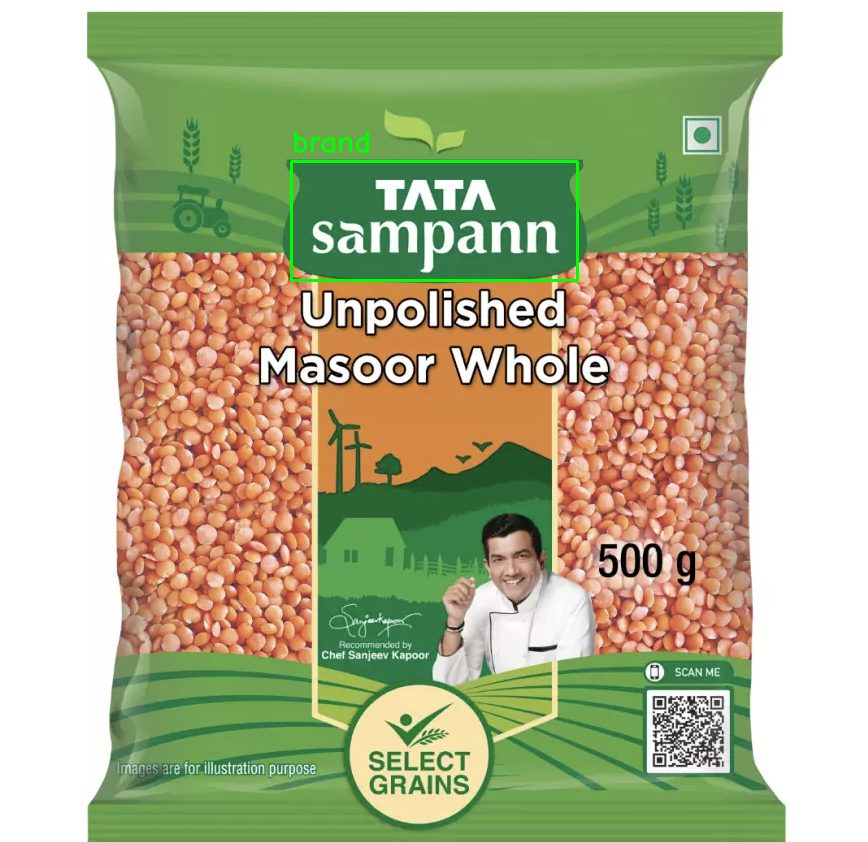

In [25]:
import cv2
from google.colab.patches import cv2_imshow  # Use this if you're running on Google Colab

# Load the original image to draw bounding boxes on
original_image = cv2.imread(image_path)

# Draw bounding boxes on the original image
for prediction in predictions['predictions']:
    x_min = int(prediction['x'] - prediction['width'] / 2)
    y_min = int(prediction['y'] - prediction['height'] / 2)
    x_max = int(prediction['x'] + prediction['width'] / 2)
    y_max = int(prediction['y'] + prediction['height'] / 2)

    # Draw rectangle on the image (Green color, thickness of 2)
    cv2.rectangle(original_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    # Optionally, you can put the label text as well
    label = prediction['class']  # Class label
    cv2.putText(original_image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Display the image with bounding boxes
cv2_imshow(original_image)  # For Google Colab



In [26]:
# Extract bounding box coordinates from predictions
def extract_bounding_boxes(predictions):
    bounding_boxes = []
    for pred in predictions['predictions']:
        # Each prediction contains bounding box coordinates and class label
        x = pred['x']
        y = pred['y']
        width = pred['width']
        height = pred['height']
        Label = pred['class']  # Class name (should be "label" in your case)

        # Compute bounding box coordinates
        x_min = int(x - width / 2)
        y_min = int(y - height / 2)
        x_max = int(x + width / 2)
        y_max = int(y + height / 2)

        bounding_boxes.append((x_min, y_min, x_max, y_max, Label))

    return bounding_boxes

# Extract bounding boxes
bounding_boxes = extract_bounding_boxes(predictions)
print(bounding_boxes)  # Each bounding box: (x_min, y_min, x_max, y_max, label)


[(291, 161, 577, 280, 'brand')]


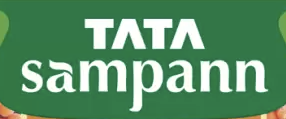

In [27]:
import cv2
from google.colab.patches import cv2_imshow

# Load the original image using OpenCV
image = cv2.imread(image_path)

# Crop the image using bounding box coordinates
def crop_image(image, bbox):
    x_min, y_min, x_max, y_max, label = bbox
    cropped_image = image[y_min:y_max, x_min:x_max]
    return cropped_image

# Crop and display the images within the bounding boxes
for bbox in bounding_boxes:
    cropped_img = crop_image(image, bbox)
    cv2_imshow(cropped_img)  # Use cv2_imshow instead of cv2.imshow


In [28]:
import easyocr

# Initialize the EasyOCR reader
reader = easyocr.Reader(['en'])  # Use 'en' for English language


In [29]:
import cv2
import easyocr  # Assuming you are using EasyOCR for text extraction

# Initialize the OCR reader
reader = easyocr.Reader(['en'])  # Assuming the text is in English

# Function to perform OCR and return the complete detected brand name
def ocr_image(cropped_img):
    result = reader.readtext(cropped_img)
    brand_name = ""
    for (bbox, text, prob) in result:
        # Print detected text and confidence
        print(f"Detected text: {text}, Confidence: {prob}")
        # Concatenate text with a space, if confidence is above threshold
        if prob > 0.5:  # You can adjust the confidence threshold
            brand_name += text + " "

    # Strip any trailing spaces
    return brand_name.strip()

# Function to crop the image based on bounding box coordinates
def crop_image(image, bbox):
    x_min, y_min, x_max, y_max = bbox
    cropped_img = image[y_min:y_max, x_min:x_max]
    return cropped_img

# Example bounding_boxes list (adjust based on your actual data structure)
bounding_boxes = [
    (x_min, y_min, x_max, y_max)  # Replace with actual coordinates
]

# Load the original image
image = cv2.imread(image_path)

# Perform OCR on each cropped image and print the detected full brand name
for bbox in bounding_boxes:
    cropped_img = crop_image(image, bbox)
    detected_brand = ocr_image(cropped_img)
    if detected_brand:
        print(f"Detected Full Brand Name: {detected_brand}")


Detected text: TATA, Confidence: 0.9844903945922852
Detected text: sampann, Confidence: 0.8049023097951388
Detected Full Brand Name: TATA sampann


 .
